In [1]:
import os
import sys
from pathlib import Path

# Добавляем путь на уровень выше
sys.path.append(str(Path(os.getcwd()).resolve().parent))

from utils.features import *
from utils.load_data import load_all_data
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
data_dir = Path('../data/PEMS-BAY')
metadata, data, adj = load_all_data(data_dir)
data = data[:2016]

In [3]:
np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)
betweenness_centrality = nx.betweenness_centrality(G)
# Получаем значения betweenness_centrality
bc_values = list(betweenness_centrality.values())

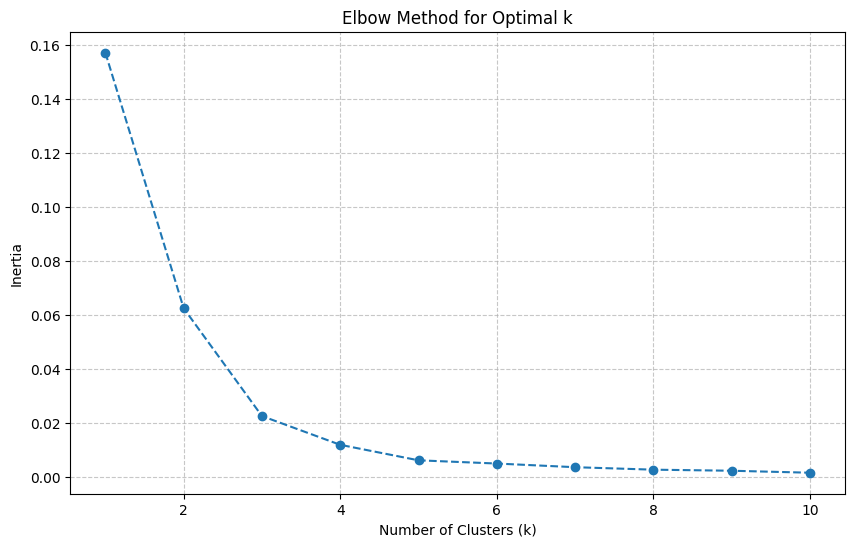

In [4]:
# Вычисляем сумму квадратов расстояний для разных значений k
inertia = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.array(bc_values).reshape(-1, 1))
    inertia.append(kmeans.inertia_)

# Строим график "локтя"
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

In [5]:
# Применяем K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(np.array(bc_values).reshape(-1, 1))

# Получаем метки кластеров
labels = kmeans.labels_

# Создаем группы узлов на основе меток
groups = [[] for _ in range(5)]  # 5 групп, так как n_clusters=5
for node, label in zip(betweenness_centrality.keys(), labels):
    groups[label].append(node)

In [6]:
# Создаем массив для хранения средних скоростей по группам
# Форма: (time_steps, num_groups)
group_average_speeds = np.zeros((data.shape[0], 5))  # 5 групп

for i, group in enumerate(groups):
    # Выбираем данные для узлов в группе
    group_data = data[:, group, 0]  # Форма: (time_steps, num_nodes_in_group)
    
    # Усредняем по узлам (axis=1), сохраняя временной ряд
    group_average_speeds[:, i] = np.mean(group_data, axis=1)

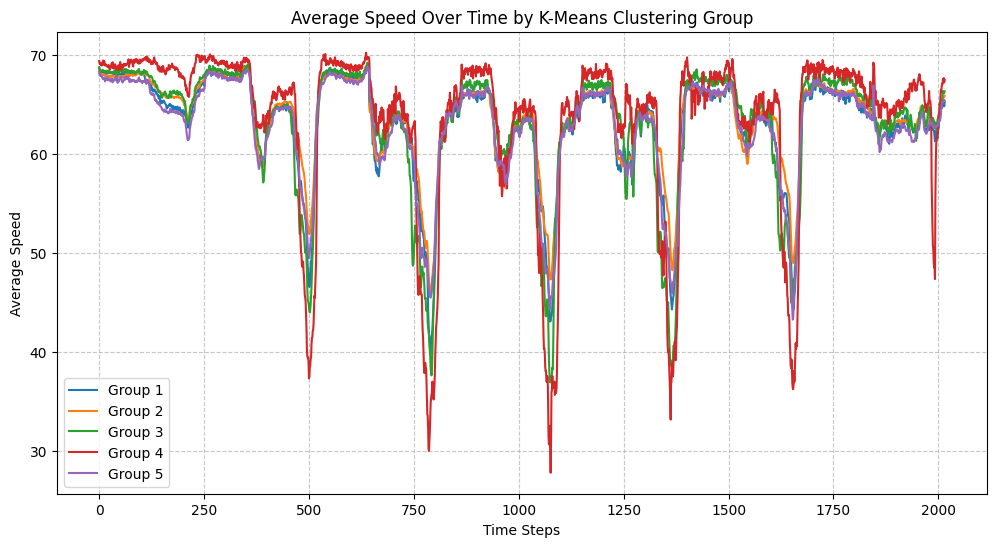

In [7]:
import matplotlib.pyplot as plt

# Временные метки (если есть)
time_steps = np.arange(data.shape[0])

# Построение графика
plt.figure(figsize=(12, 6))

for i in range(5):  # 5 групп
    plt.plot(time_steps, group_average_speeds[:, i], label=f'Group {i+1}')

plt.xlabel('Time Steps')
plt.ylabel('Average Speed')
plt.title('Average Speed Over Time by K-Means Clustering Group')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

In [12]:
from sklearn.cluster import KMeans
import numpy as np
import plotly.graph_objects as go

np.fill_diagonal(adj, 0)
G = nx.from_numpy_array(adj)
betweenness_centrality = nx.betweenness_centrality(G)

# 1. Применяем K-Means
bc_values = list(betweenness_centrality.values())
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(np.array(bc_values).reshape(-1, 1))
labels = kmeans.labels_

# 2. Создаем группы узлов
groups = [[] for _ in range(5)]
for node, label in zip(betweenness_centrality.keys(), labels):
    groups[label].append(node)

# 3. Вычисляем средние скорости для каждой группы
group_average_speeds = np.zeros((data.shape[0], 5))
for i, group in enumerate(groups):
    group_data = data[:, group, 0]
    group_average_speeds[:, i] = np.mean(group_data, axis=1)

# 4. Построение графика с использованием Plotly
time_steps = np.arange(data.shape[0])

fig = go.Figure()
for i in range(5):
    fig.add_trace(go.Scatter(
        x=time_steps,
        y=group_average_speeds[:, i],
        mode='lines',
        name=f'Group {i+1} (Centroid: {kmeans.cluster_centers_[i][0]:.4f})'
    ))

fig.update_layout(
    title='Average Speed Over Time by K-Means Clustering Group',
    xaxis_title='Time Steps',
    yaxis_title='Average Speed',
    legend_title='Groups',
    template='plotly_white'
)

fig.show()